In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/chenzhao/useful/scripts/python/pyFFTps')
import pyFFTps
import pyFFTps.PowerSpec as PS

# Equal-spacing

$$
\begin{aligned}
C_m^{\text {int-1D }}(k) & =|W(k)|^2 \sum_{n=m l}\left(\frac{k}{k-n k_H}\right)^{2 p}=|W(k)|^2 \sum_l\left(\frac{k}{k-m l k_H}\right)^{2 p} \\
& =|W(k)|^2 \sum_l\left(\frac{k / m}{k / m-l k_H}\right)^{2 p}=\frac{|W(k)|^2}{|W(k / m)|^2} C(k / m) \\
& =\frac{\sin ^{2 p}\left(\frac{\pi k}{k_H}\right)}{m^{2 p} \sin ^{2 p}\left(\frac{\pi k}{m k_H}\right)} S_{2 p}\left[\sin ^2\left(\frac{\pi k}{m k_H}\right)\right]
\end{aligned}
$$

Number density = 1.562500e-02 h^3/Mpc^3


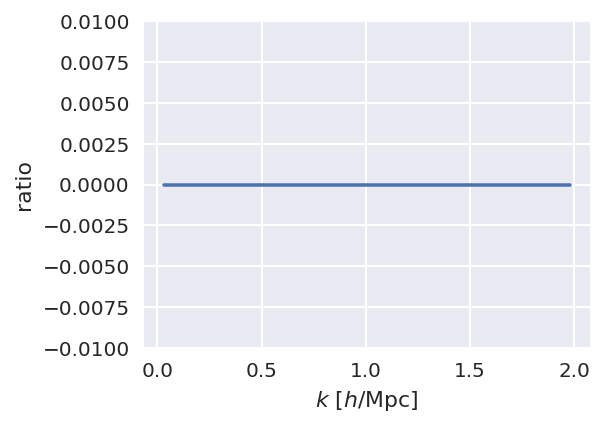

In [2]:
# Here just keep the first term for the interlaced shot noise
def IsotropicShotNoise(k, BoxSize, Nmesh, numden, MAS, interlaced):
    '''
    k: the wavenumber in unit of h/Mpc
    BoxSize: the size of the simulation box in unit of Mpc^3/h^3
    Nmesh: the number of cells per dimension
    MAS: the mass assignment scheme, e.g., 'CIC', 'TSC', 'PCS'
    numden: number density of the tracers in unit of h^3/Mpc^3
    interlaced: whether the density field is interlaced or not
    '''
    kH   = 2*np.pi*Nmesh/BoxSize
    if interlaced:
        cosk2 = np.cos(np.pi*k/kH/2)
        sink2 = np.sin(np.pi*k/kH/2)
        if   MAS == 'NGP': Ck = cosk2**2
        elif MAS == 'CIC': Ck = cosk2**4*(1 - 2/3 * sink2**2)
        elif MAS == 'TSC': Ck = cosk2**6*(1 - sink2**2 + 2/15 * sink2**4)
        elif MAS == 'PCS': Ck = cosk2**8*(1 - 4/3 * sink2**2 + 2/5 * sink2**4 - 4/315 * sink2**6)
        else: raise ValueError("MAS method not supported.")
    else:
        sink = np.sin(np.pi*k/kH)
        if   MAS == 'NGP': Ck = 1
        elif MAS == 'CIC': Ck = 1 - 2/3 * sink**2
        elif MAS == 'TSC': Ck = 1 - sink**2 + 2/15 * sink**4
        elif MAS == 'PCS': Ck = 1 - 4/3 * sink**2 + 2/5 * sink**4 - 4/315 * sink**6
        else: raise ValueError("MAS method not supported.")
    return Ck/numden

def Cint_1D_nshift(k, BoxSize, Nmesh, numden, MAS, nshift, order=2):
    m  = order
    kH = 2*np.pi*Nmesh/BoxSize
    x  = np.pi*k/kH
    sinx2  = np.sin(x )*np.sin(x )
    xm = np.pi*k/kH/m - np.pi*nshift/m
    sinxm2 = np.sin(xm)*np.sin(xm)
    if   MAS == 'NGP': 
        S2p = 1
        p   = 1
    elif MAS == 'CIC': 
        S2p = 1 - 2/3*sinxm2
        p   = 2
    elif MAS == 'TSC': 
        S2p = 1 - sinxm2 + 2/15*sinxm2*sinxm2
        p   = 3
    elif MAS == 'PCS': 
        S2p = 1 - 4/3*sinxm2 + 2/5*sinxm2*sinxm2 - 4/315*sinxm2*sinxm2*sinxm2
        p   = 4
    else: raise ValueError("MAS method not supported.")
    return (sinx2/m/m/sinxm2)**p*S2p/numden

## 50 Mpc/h box, 128^3 mesh
Nmesh   = 64
BoxSize = 100.0
numtot  = int(25**3)

sn = BoxSize**3/numtot # shot noise
numden = numtot/BoxSize**3
print('Number density = %e h^3/Mpc^3'%numden)

ktt  = np.arange(1, Nmesh) * np.pi/BoxSize
pki  = IsotropicShotNoise(ktt, BoxSize, Nmesh, numden, 'CIC', interlaced=True)
pkii = Cint_1D_nshift(ktt, BoxSize, Nmesh, numden, 'CIC', nshift=0, order=2)

with plt.style.context('seaborn'):
    plt.figure(figsize=(4,3))
    plt.plot(ktt, pkii/pki - 1)
    plt.grid(True)
    plt.ylim([-0.01, 0.01])
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'ratio')

In [3]:
# def Interlacing(MassAssign, pos, number, BoxSize, Nmesh, threads=1):
#     delta_k   = np.zeros((Nmesh,Nmesh,Nmesh//2+1),dtype=np.complex64)
#     karr      = np.fft.fftfreq(Nmesh,1.0/Nmesh).astype(np.float32) * 2 * np.pi / Nmesh 
#     karr[Nmesh//2] = Nmesh / 2 ## change the -Nmesh/2 to Nmesh/2 consistent with rfftfreq
#     karrz     = np.fft.rfftfreq(Nmesh,1.0/Nmesh).astype(np.float32) * 2 * np.pi / Nmesh 
#     karr      = np.sum(np.meshgrid(karr, karr, karrz, indexing='ij'), axis=0)
#     numberint = np.zeros_like(number)
#     MassAssign(pos,number,BoxSize)
#     #interlacing shift start
#     pos[:] = pos[:] + 0.5*BoxSize/Nmesh 
#     pos[pos>=BoxSize] -= BoxSize
#     pos[pos<0] += BoxSize
#     #interlacing shift end
#     MassAssign(pos,numberint,BoxSize)
#     delta_k[:]  = PS.FFT3Dr_f(numberint,threads)
#     delta_k[:]  = 0.5*delta_k[:]*np.exp(1j * karr[:] * 0.5)
#     delta_k[:]  = delta_k[:] + 0.5*PS.FFT3Dr_f(number,threads)
#     number[:]   = PS.IFFT3Dr_f(delta_k,threads)
#     del delta_k, numberint, karr
#     # return number

def Interlacing(MassAssign, pos_in, number, BoxSize, Nmesh, threads=1, order=2):
    pos = np.copy(pos_in)
    
    karr      = np.fft.fftfreq(Nmesh,1.0/Nmesh).astype(np.float32)  * 2 * np.pi / Nmesh 
    karr[Nmesh//2] = np.pi / 2 ## change the -Nmesh/2 to Nmesh/2 consistent with rfftfreq
    karrz     = np.fft.rfftfreq(Nmesh,1.0/Nmesh).astype(np.float32) * 2 * np.pi / Nmesh 
    karr      = np.sum(np.meshgrid(karr, karr, karrz, indexing='ij'), axis=0)
    MassAssign(pos,number,BoxSize)
    delta_k   = np.zeros((Nmesh,Nmesh,Nmesh//2+1),dtype=np.complex64)
    delta_k[:]  = 1/order*PS.FFT3Dr_f(number,threads)
    
    numberint = np.zeros((order-1), dtype=object)
    for i in range(order-1):
        numberint[i] = np.zeros_like(number)
        shift = (i+1)/order
        #interlacing shift start
        # pos[:] = pos_in[:] + shift*BoxSize/Nmesh 
        pos[:] = pos[:] + 1/order*BoxSize/Nmesh
        pos[pos>=BoxSize] -= BoxSize
        pos[pos<0] += BoxSize
        #interlacing shift end
        MassAssign(pos,numberint[i],BoxSize)
        delta_k[:] += 1/order*PS.FFT3Dr_f(numberint[i], threads)*np.exp(1j * karr[:] * shift)
    number[:]   = PS.IFFT3Dr_f(delta_k,threads)
    del delta_k, numberint, karr, pos

kmax = np.pi*Nmesh/BoxSize
kmin = 2*np.pi/BoxSize
kbin = int(Nmesh/2)  

In [4]:
def GenerateAm(m=3):
    Am = []
    for i in range(m):
        for j in range(m):
            for k in range(m):
                if (i+j+k) % m == 0: 
                    Am.append(np.array([i,j,k]))
                else:
                    continue
    return np.array(Am)

def FieldShotNoise(BoxSize, Nmesh, numden, MAS, interlaced, kmax, kmin, kbin, order=2, isotropic=False, Wcorr=False):
    '''
    BoxSize: the size of the simulation box in unit of Mpc^3/h^3
    Nmesh: the number of cells per dimension
    MAS: the mass assignment scheme, e.g., 'CIC', 'TSC', 'PCS'
    numden: number density of the tracers in unit of h^3/Mpc^3
    interlaced: whether the density field is interlaced or not
    '''
    m    = order
    kH   = 2*np.pi*Nmesh/BoxSize
    if interlaced:
        ## Here only the even terms
        if   MAS == 'NGP': 
            p  = 1
            Ck = lambda x, n: 1
        elif MAS == 'CIC':
            p  = 2
            Ck = lambda x, n: (1 - 2/3*np.sin(x/m - np.pi*n/m)**2)
        elif MAS == 'TSC':
            p  = 3
            Ck = lambda x, n: (1 - np.sin(x/m - np.pi*n/m)**2 + 2/15*np.sin(x/m - np.pi*n/m)**4)
        elif MAS == 'PCS':
            p  = 4
            Ck = lambda x, n: (1 - 4/3*np.sin(x/m - np.pi*n/m)**2 + 2/5*np.sin(x/m - np.pi*n/m)**4 - 4/315*np.sin(x/m - np.pi*n/m)**6)
        else: 
            raise ValueError("MAS method not supported.")        
        def Ak(x,n):
            afac = np.zeros_like(x)
            ind  = (x != 0) + (n != 0)
            afac[ind] = (np.sin(x[ind])/m/np.sin(x[ind]/m - np.pi*n/m))**(2*p)
            ind  = (x == 0) * (n == 0)
            afac[ind] = 1
            return afac 
           
    else:
        if   MAS == 'NGP': 
            p   = 1
            Ck  = lambda x: 1
        elif MAS == 'CIC':
            p   = 2
            Ck  = lambda x: 1 - 2/3*np.sin(x)**2
        elif MAS == 'TSC':
            p   = 3
            Ck  = lambda x: 1 - np.sin(x)**2 + 2/15*np.sin(x)**4
        elif MAS == 'PCS':
            p   = 4
            Ck  = lambda x: 1 - 4/3*np.sin(x)**2 + 2/5*np.sin(x)**4 - 4/315*np.sin(x)**6
        else: 
            raise ValueError("MAS method not supported.")
    karr           = np.fft.fftfreq(Nmesh, 1.0/Nmesh).astype(np.float32)  * np.pi / Nmesh 
    karr[Nmesh//2] = np.pi / 2   ## change the -Nmesh/2 to Nmesh/2 consistent with rfftfreq [-pi/2, pi/2]
    karrz          = np.fft.rfftfreq(Nmesh, 1.0/Nmesh).astype(np.float32) * np.pi / Nmesh
    nx, ny, nz     = np.meshgrid(karr, karr, karrz, indexing='ij')
    deltasquare_k_sn     = np.zeros((Nmesh, Nmesh, Nmesh//2+1), dtype=np.float32) # only real part
    if isotropic:
        nr = np.sqrt(nx*nx + ny*ny + nz*nz)
        if interlaced:
            deltasquare_k_sn[:] = Ck(nr,0)*Ak(nr,0)/numden
        else:
            deltasquare_k_sn[:]  = Ck(nr)/numden
    else:
        if interlaced:
            Amlists = GenerateAm(m)
            for Am in Amlists:
            # for Am in [[0,0,0]]:
                deltasquare_k_sn[:] += (Ck(nx, Am[0])*Ck(ny, Am[1])*Ck(nz, Am[2]))*(Ak(nx, Am[0])*Ak(ny, Am[1])*Ak(nz, Am[2]))/numden
        else:
            deltasquare_k_sn[:]  = (Ck(nx)*Ck(ny)*Ck(nz)/numden)
    
    MAS_corr = np.zeros((3), dtype=np.float32)
    kF   = 2*np.pi/BoxSize
    kmax = kmax/kF; kmin = kmin/kF
    # define Bins and arrays 
    dk = (kmax-kmin)/(kbin-1)
    k1D      = np.zeros(kbin-1, dtype=np.float64)
    Pk1D     = np.zeros(kbin-1, dtype=np.float64)
    Nmodes1D = np.zeros(kbin-1, dtype=np.float64)
    middle = Nmesh//2
    for i in range(Nmesh):
        ki = i - Nmesh if i >= middle else i
        MAS_corr[0] = 1/np.sinc(ki/Nmesh)**p
        for j in range(Nmesh):
            kj = j - Nmesh if j >= middle else j
            MAS_corr[1] = 1/np.sinc(kj/Nmesh)**p
            for k in range(Nmesh//2+1):
                kk = k - Nmesh if k >= middle else k
                modefactor = 2
                if (k==middle) or (k==0) : modefactor = 1
                MAS_corr[2] = 1/np.sinc(kk/Nmesh)**p
                kr = np.sqrt(ki*ki + kj*kj + kk*kk)
                if (kr >= kmax) or (kr < kmin): continue
                k_index = int((kr-kmin)/dk)
                
                if isotropic:
                    MAS_factor = 1/np.sinc(kr/Nmesh)**(p)
                else:
                    MAS_factor = MAS_corr[0]*MAS_corr[1]*MAS_corr[2]
                if Wcorr:
                    MAS_factor = MAS_factor
                else:
                    MAS_factor = 1.0
                delta2 = deltasquare_k_sn[i,j,k]*MAS_factor*MAS_factor

                ## Here PK1D means 1D power spectrum not 1D k (in Pylians)
                k1D[k_index]      += kr * modefactor
                Pk1D[k_index]     += delta2 * modefactor
                Nmodes1D[k_index] += 1.0 * modefactor  
    
    for i in range(len(k1D)):
        if Nmodes1D[i]==0:
            k1D[i] = np.nan
            Pk1D[i] = np.nan
        else:
            k1D[i]  = (k1D[i]/Nmodes1D[i])*kF  #give units
            Pk1D[i] = (Pk1D[i]/Nmodes1D[i])    #aleady physical units
    return k1D, Pk1D, Nmodes1D

## interlacing = 2

In [5]:
rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)

delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=2)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))

-4.3655746e-09 -4.422827 21.280272


In [6]:
pk2 = pyFFTps.Pk1D(delta, BoxSize, MAS='None', verbose=True, threads=1, 
                   interlaced=False, numeff=1.0, SNFlag=False,
                   kmin=kmin, kmax=kmax, kbin=kbin)


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


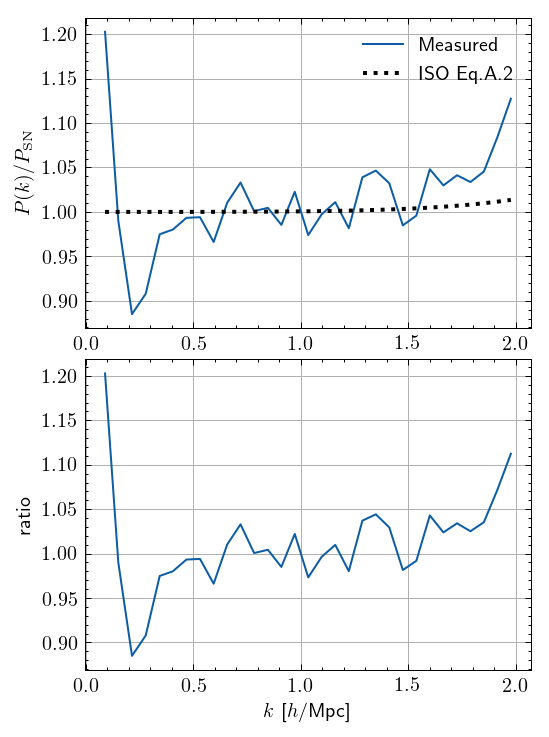

In [7]:
import scienceplots
kH = 2*np.pi/BoxSize*Nmesh
Wk = np.sinc(pk2[0]/kH)**2
sn = BoxSize**3/numtot # shot noise
numden = numtot/BoxSize**3

pki = IsotropicShotNoise(pk2[0], BoxSize, Nmesh, numden, 'CIC', True)

gridp = plt.GridSpec(2, 1, hspace=0.1)
with plt.style.context(['science']):
    plt.figure(figsize=(4, 6))
    ax0 = plt.subplot(gridp[0])
    plt.plot(pk2[0], pk2[1]/sn/Wk/Wk)
    plt.plot(pk2[0], pki/sn/Wk/Wk, 'k:', lw=2.0)
    # plt.xscale('log')
    plt.grid(True)
    plt.legend(['Measured', 'ISO Eq.A.2'])
    plt.ylabel(r'$P(k)/P_{\rm SN}$')
    ax1 = plt.subplot(gridp[1])
    plt.plot(pk2[0], pk2[1]/pki)
    # plt.xscale('log')
    plt.grid(True)
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'ratio')

In [8]:
pk_sn_iso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                           kmax=kmax, kmin=kmin, kbin=kbin, 
                           interlaced=True, order=2, Wcorr=True,
                           isotropic=True)
dk = (kmax-kmin)/(kbin-1)
print(dk, 2*np.pi/BoxSize)

0.06283185307179587 0.06283185307179587


In [9]:
pk_sn_aniso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                             kmax=kmax, kmin=kmin, kbin=kbin, 
                             interlaced=True, order=2, Wcorr=True, 
                             isotropic=False)

In [10]:
rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)

delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=2)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))
pk2_w = pyFFTps.Pk1D(delta, BoxSize, MAS='CIC', verbose=True, threads=1, 
                     interlaced=False, numeff=1.0, SNFlag=False,
                     kmin=kmin, kmax=kmax, kbin=kbin)

-4.3655746e-09 -4.422827 21.280272

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


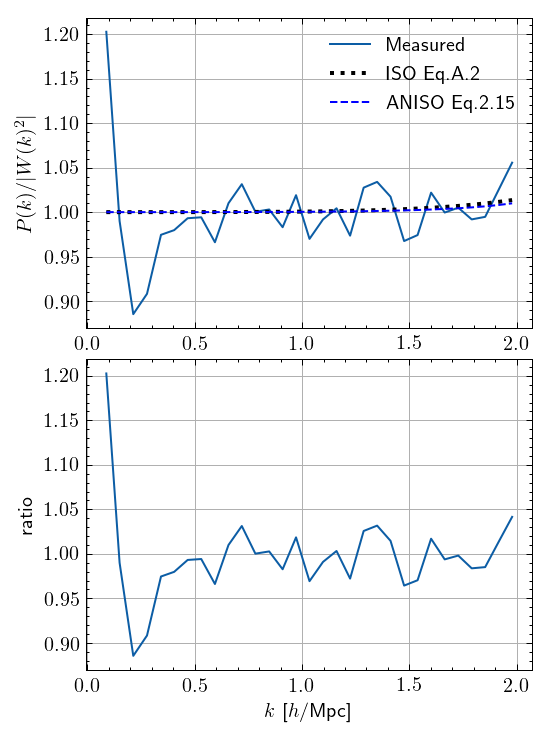

In [11]:
import scienceplots

sn = BoxSize**3/numtot # shot noise
numden = numtot/BoxSize**3

gridp = plt.GridSpec(2, 1, hspace=0.1)
with plt.style.context(['science']):
    plt.figure(figsize=(4, 6))
    ax0 = plt.subplot(gridp[0])
    plt.plot(pk2[0], pk2_w[1]/sn)
    plt.plot(pk2[0], pk_sn_iso[1]/sn, 'k:', lw=2.0)
    plt.plot(pk2[0], pk_sn_aniso[1]/sn, 'b--') 
    # plt.xscale('log')
    plt.grid(True)
    plt.legend(['Measured', 'ISO Eq.A.2', 'ANISO Eq.2.15'])
    
    plt.ylabel(r'$P(k)/|W(k)^2|$')
    ax1 = plt.subplot(gridp[1])
    plt.plot(pk2[0], pk2_w[1]/pk_sn_iso[1])
    # plt.xscale('log')
    plt.grid(True)
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'ratio')

## interlacing = 3

In [12]:
rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)
delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=3)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))
pk3_w = pyFFTps.Pk1D(delta, BoxSize, MAS='CIC', verbose=True, threads=1, 
                     interlaced=False, numeff=1.0, SNFlag=False,
                     kmin=kmin, kmax=kmax, kbin=kbin)

6.204937e-08 -4.248156 20.534405

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


In [13]:
pk3_sn_iso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                            kmax=kmax, kmin=kmin, kbin=kbin, 
                            interlaced=True, order=3, Wcorr=True, 
                            isotropic=True)
pk3_sn_aniso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                              kmax=kmax, kmin=kmin, kbin=kbin, 
                              interlaced=True, order=3, Wcorr=True, 
                              isotropic=False)


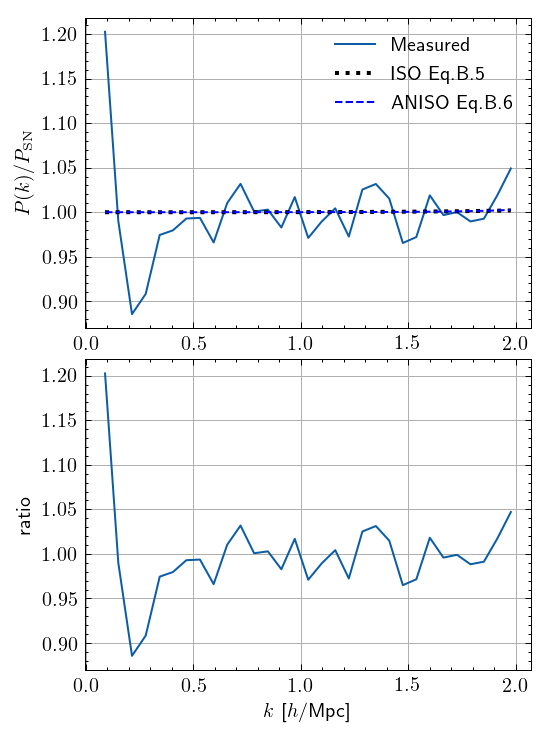

In [14]:
import scienceplots

sn = BoxSize**3/numtot # shot noise
numden = numtot/BoxSize**3

gridp = plt.GridSpec(2, 1, hspace=0.1)
with plt.style.context(['science']):
    plt.figure(figsize=(4, 6))
    ax0 = plt.subplot(gridp[0])
    plt.plot(pk3_w[0], pk3_w[1]/sn)
    plt.plot(pk3_w[0], pk3_sn_iso[1]/sn, 'k:', lw=2.0)
    plt.plot(pk3_w[0], pk3_sn_aniso[1]/sn, 'b--')
    # plt.xscale('log')
    plt.grid(True)
    plt.legend(['Measured', 'ISO Eq.B.5', 'ANISO Eq.B.6'])
    plt.ylabel(r'$P(k)/P_{\rm SN}$')
    ax1 = plt.subplot(gridp[1])
    plt.plot(pk3_w[0], pk3_w[1]/pk3_sn_iso[1])
    # plt.xscale('log')
    plt.grid(True)
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'ratio')

## interlacing = 4

In [15]:
rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)
delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=4)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))
pk4_w = pyFFTps.Pk1D(delta, BoxSize, MAS='CIC', verbose=True, threads=1, 
                     interlaced=False, numeff=1.0, SNFlag=False,
                     kmin=kmin, kmax=kmax, kbin=kbin)

2.4790643e-07 -4.226776 20.272081

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


In [16]:
pk4_sn_iso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                            kmax=kmax, kmin=kmin, kbin=kbin, 
                            interlaced=True, order=4, Wcorr=True, 
                            isotropic=True)
pk4_sn_aniso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                              kmax=kmax, kmin=kmin, kbin=kbin, 
                              interlaced=True, order=4, Wcorr=True, 
                              isotropic=False)

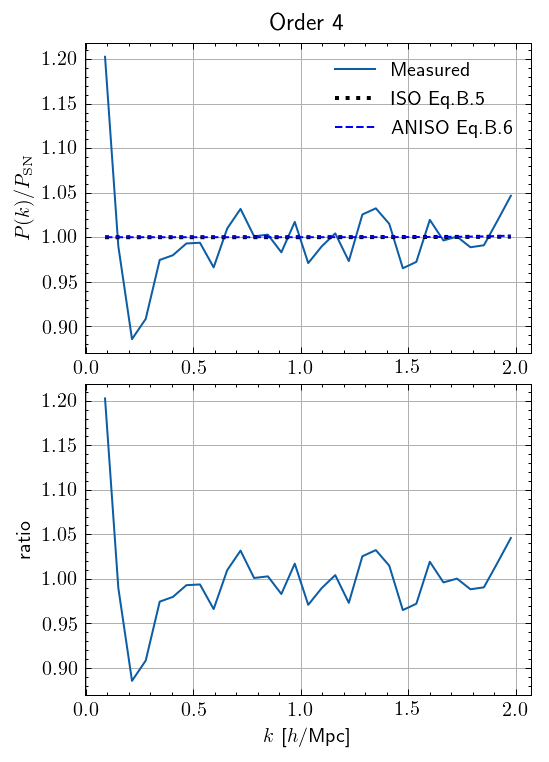

In [17]:
import scienceplots

sn = BoxSize**3/numtot # shot noise
numden = numtot/BoxSize**3

gridp = plt.GridSpec(2, 1, hspace=0.1)
with plt.style.context(['science']):
    plt.figure(figsize=(4, 6))
    ax0 = plt.subplot(gridp[0])
    plt.plot(pk4_w[0], pk4_w[1]/sn)
    plt.plot(pk4_w[0], pk4_sn_iso[1]/sn, 'k:', lw=2.0)
    plt.plot(pk4_w[0], pk4_sn_aniso[1]/sn, 'b--')
    # plt.xscale('log')
    plt.grid(True)
    plt.title('Order 4')
    plt.legend(['Measured', 'ISO Eq.B.5', 'ANISO Eq.B.6'])
    plt.ylabel(r'$P(k)/P_{\rm SN}$')
    ax1 = plt.subplot(gridp[1])
    plt.plot(pk4_w[0], pk4_w[1]/pk4_sn_iso[1])
    # plt.xscale('log')
    plt.grid(True)
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'ratio')

## interlacing = 8

In [18]:
rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)
delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=8)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))
pk8_w = pyFFTps.Pk1D(delta, BoxSize, MAS='CIC', verbose=True, threads=1, 
                     interlaced=False, numeff=1.0, SNFlag=False,
                     kmin=kmin, kmax=kmax, kbin=kbin)

rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)
delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=8)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))
pk8 = pyFFTps.Pk1D(delta, BoxSize, MAS='None', verbose=True, threads=1, 
                   interlaced=False, numeff=1.0, SNFlag=False,
                   kmin=kmin, kmax=kmax, kbin=kbin)

4.132744e-09 -4.2381034 20.16868

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds
4.132744e-09 -4.2381034 20.16868

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


In [19]:
pk8_sn_iso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                            kmax=kmax, kmin=kmin, kbin=kbin, 
                            interlaced=True, order=8, Wcorr=True, 
                            isotropic=True)
pk8_sn_aniso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                              kmax=kmax, kmin=kmin, kbin=kbin, 
                              interlaced=True, order=8, Wcorr=True, 
                              isotropic=False)

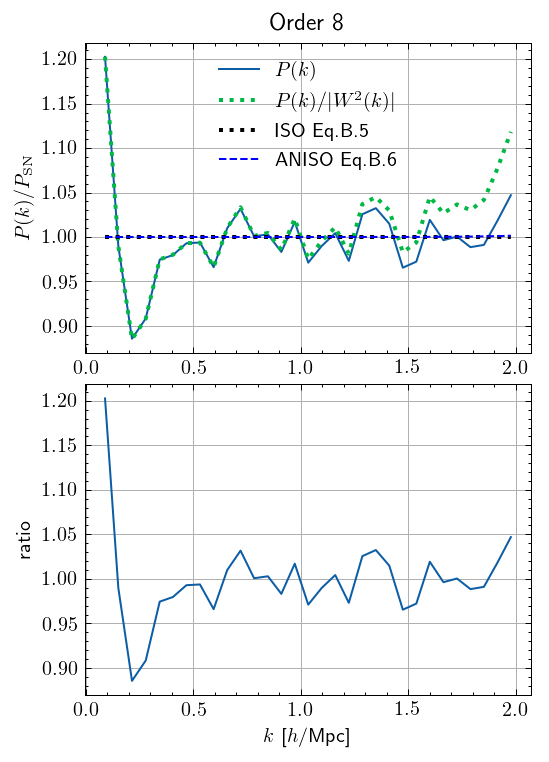

In [25]:
import scienceplots

sn = BoxSize**3/numtot # shot noise
numden = numtot/BoxSize**3
kH = 2*np.pi/BoxSize*Nmesh
Wk = np.sinc(pk8_w[0]/kH)**2

gridp = plt.GridSpec(2, 1, hspace=0.1)
with plt.style.context(['science']):
    plt.figure(figsize=(4, 6))
    ax0 = plt.subplot(gridp[0])
    plt.plot(pk8_w[0], pk8_w[1]/sn, label=r'$P(k)$')
    plt.plot(pk8_w[0], pk8[1]/sn/Wk/Wk, ':', lw=2.0, label=r'$P(k)/|W^2(k)|$')
    plt.plot(pk8_w[0], pk8_sn_iso[1]/sn, 'k:', lw=2.0, label='ISO Eq.B.5')
    plt.plot(pk8_w[0], pk8_sn_aniso[1]/sn, 'b--', label='ANISO Eq.B.6')
    # plt.xscale('log')
    plt.grid(True)
    plt.title('Order 8')
    plt.legend()
    plt.ylabel(r'$P(k)/P_{\rm SN}$')
    # plt.ylim(0.99, 1.1)
    ax1 = plt.subplot(gridp[1])
    plt.plot(pk8_w[0], pk8_w[1]/pk8_sn_iso[1])
    # plt.xscale('log')
    plt.grid(True)
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'ratio')

## test package

In [5]:
rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)
delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
pyFFTps.MAS_pyl.MA(pos, delta, BoxSize, W=None, MAS='CIC', interlaced=True, verbose=True, threads=1, order=8)
# Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=8)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))
pk8_w = pyFFTps.Pk1D(delta, BoxSize, MAS='CIC', verbose=True, threads=1, 
                     interlaced=False, numeff=1.0, SNFlag=False,
                     kmin=kmin, kmax=kmax, kbin=kbin)

rng     = np.random.RandomState(100318)
pos     = rng.rand(numtot,3)*BoxSize
pos = pos.astype(np.float32)
delta   = np.zeros((Nmesh, Nmesh, Nmesh),dtype=np.float32)
Interlacing(pyFFTps.MAS_pyl.CIC, pos, delta, BoxSize, Nmesh, order=8)
delta = delta/np.mean(delta) - 1.0
print(np.mean(delta), np.min(delta), np.max(delta))
pk8 = pyFFTps.Pk1D(delta, BoxSize, MAS='None', verbose=True, threads=1, 
                   interlaced=False, numeff=1.0, SNFlag=False,
                   kmin=kmin, kmax=kmax, kbin=kbin)


Using CIC mass assignment scheme
Interlacing the density field
Time taken = 0.064 seconds

4.132744e-09 -4.2381034 20.16868

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds
4.132744e-09 -4.2381034 20.16868

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


In [6]:
pk8_sn_iso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                            kmax=kmax, kmin=kmin, kbin=kbin, 
                            interlaced=True, order=8, Wcorr=True, 
                            isotropic=True)
pk8_sn_aniso = FieldShotNoise(BoxSize, Nmesh, numden, 'CIC', 
                              kmax=kmax, kmin=kmin, kbin=kbin, 
                              interlaced=True, order=8, Wcorr=True, 
                              isotropic=False)

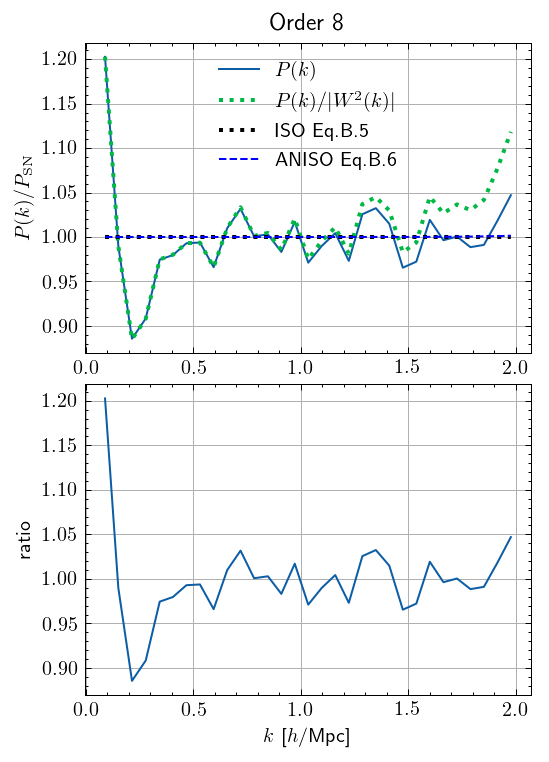

In [7]:
import scienceplots

sn = BoxSize**3/numtot # shot noise
numden = numtot/BoxSize**3
kH = 2*np.pi/BoxSize*Nmesh
Wk = np.sinc(pk8_w[0]/kH)**2

gridp = plt.GridSpec(2, 1, hspace=0.1)
with plt.style.context(['science']):
    plt.figure(figsize=(4, 6))
    ax0 = plt.subplot(gridp[0])
    plt.plot(pk8_w[0], pk8_w[1]/sn, label=r'$P(k)$')
    plt.plot(pk8_w[0], pk8[1]/sn/Wk/Wk, ':', lw=2.0, label=r'$P(k)/|W^2(k)|$')
    plt.plot(pk8_w[0], pk8_sn_iso[1]/sn, 'k:', lw=2.0, label='ISO Eq.B.5')
    plt.plot(pk8_w[0], pk8_sn_aniso[1]/sn, 'b--', label='ANISO Eq.B.6')
    # plt.xscale('log')
    plt.grid(True)
    plt.title('Order 8')
    plt.legend()
    plt.ylabel(r'$P(k)/P_{\rm SN}$')
    # plt.ylim(0.99, 1.1)
    ax1 = plt.subplot(gridp[1])
    plt.plot(pk8_w[0], pk8_w[1]/pk8_sn_iso[1])
    # plt.xscale('log')
    plt.grid(True)
    plt.xlabel(r'$k$ [$h$/Mpc]')
    plt.ylabel(r'ratio')